In [12]:
import torch.distributions
import torchvision
import numpy as np

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# importando função que mostra imagens no jupyter notebook
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
# Importando bibliotecas usadas na comparação dos algoritmos
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
import seaborn as sns
import torch.distributions
import torchvision
import numpy as np
import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid


In [2]:
train_dataset = torchvision.datasets.MNIST('./data', 
                                            transform=torchvision.transforms.ToTensor(), 
                                            train=True,
                                            download=True)

val_dataset = torchvision.datasets.MNIST('./data', 
                                            transform=torchvision.transforms.ToTensor(), 
                                            train=False,
                                            download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)





In [3]:
for a in train_loader:
    print(a[0].shape)
    break

torch.Size([128, 1, 28, 28])


In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dims,input_size):
        input_=np.prod(input_size)
        print(input_)
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(28*28, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1) # it flattens the image x by transforming it to 1-d tensor
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))        
        x = F.relu(self.linear3(x))

        return self.linear4(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dims,input_size):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 512)
        self.linear4 = nn.Linear(512, 28*28)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))        
        z = F.relu(self.linear3(z))
        z = torch.sigmoid(self.linear4(z))

        return z.reshape((-1, 1,28,28)) # it transforms the generated tensor into image
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims,input_size):
        
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims,input_size)
        self.decoder = Decoder(latent_dims,input_size)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)  
    
    
    
def train(model, train_loader, val_loader, epochs=20):
    log_dict = {"train_loss": [],
                "val_loss": [],
                "reconstructed_images":[]}    
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)    
    for epoch in tqdm.tqdm_notebook(range(epochs)):
        train_loss = []
        model.train() # set model to training mode
        for x, y in train_loader:
            x = x.to(device) # GPU
            
            opt.zero_grad()
            x_hat = model(x)
            
            loss = ((x - x_hat)**2).mean() # reconstruction loss
            train_loss.append(loss.to('cpu').detach().numpy())

            loss.backward() # compute gradients            
            opt.step() # update weights
        
        val_loss = []
        model.eval() # set model to evaluation mode
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device) # GPU
                x_hat = model(x)
                
                loss = ((x - x_hat)**2).mean() # reconstruction loss
                val_loss.append(loss.to('cpu').detach().numpy())
        
        log_dict["train_loss"].append(np.array(train_loss).mean())
        log_dict["val_loss"].append(np.array(val_loss).mean())
        log_dict["reconstructed_images"].append(x_hat.to('cpu').detach()[:5])
    log_dict["original_images"] = x.to('cpu').detach()[:5]

    return model, log_dict    
    

In [5]:
latent_dims = 16
input_size=[1, 28, 28]
#input_size=[64]
py_autoencoder = Autoencoder(latent_dims,input_size).to(device) # GPU
py_autoencoder, log_dict = train(py_autoencoder, train_loader, val_loader, epochs=50)

784


  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
def plot_loss(history):
    """
    Plot loss history
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(history['train_loss'], color='#407cdb', label='Train')
    ax.plot(history['val_loss'],color='#db5740', label='Validation')
    
    ax.legend(loc='upper left')
    handles, labels = ax.get_legend_handles_labels()  
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys())
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over the epochs')
    plt.show()

#plot_loss(log_dict)


def plot_reconstructed(log_dict, step=5):
    reconstructed_images = log_dict["reconstructed_images"]
    original_images = log_dict["original_images"]

    epochs = len(reconstructed_images)
    
    fig = plt.figure(figsize=(10,10))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(5, epochs//step + 1),
                    axes_pad=0.05)
    grid = iter(grid)
    for i in range(5):
        img = original_images[i]    
        img = img.numpy().reshape((28,28))
        ax = next(grid)
        ax.imshow(img)
        ax.set_axis_off() 

        for j in range(epochs//step):
            img = reconstructed_images[j*step][i]
            img = img.numpy().reshape((28,28))
            ax = next(grid)
            ax.imshow(img)
            ax.set_axis_off()    

    plt.show()

#plot_reconstructed(log_dict)

from sklearn.decomposition import PCA
import umap

def plot_umap_latent(autoencoder, dataloader, num_batches=100):
    latent_space = []
    labels = []
    for i, (x, y) in enumerate(dataloader):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        latent_space.append(z)
        labels.append(y)

        if i > num_batches:            
            break
    
    latent_space = np.concatenate(latent_space)
    labels = np.concatenate(labels)

    dim_reducer = umap.UMAP(n_components=2)
    latent_space_reduced = dim_reducer.fit_transform(latent_space)
    
    plt.scatter(latent_space_reduced[:, 0], latent_space_reduced[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    
    
def plot_umap_latent_TF(autoencoder, dataloader, num_batches=100):
    latent_space = []
    labels = []
    for i, (x, y) in enumerate(dataloader):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        latent_space.append(z)
        labels.append(y)

        if i > num_batches:            
            break
    
    latent_space = np.concatenate(latent_space)
    labels = np.concatenate(labels)

    dim_reducer = umap.UMAP(n_components=2)
    latent_space_reduced = dim_reducer.fit_transform(latent_space)
    
    plt.scatter(latent_space_reduced[:, 0], latent_space_reduced[:, 1], c=labels, cmap='tab10')
    plt.colorbar()

2022-11-30 18:43:47.692020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 18:43:47.812819: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-30 18:43:48.169789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-30 18:43:48.169845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

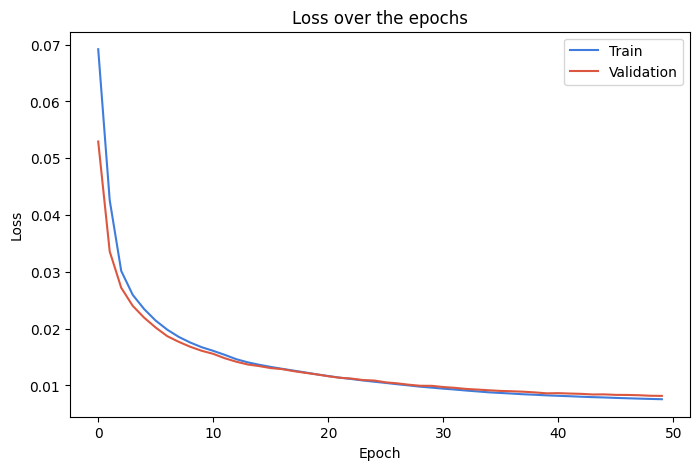

In [9]:
plot_loss(log_dict)



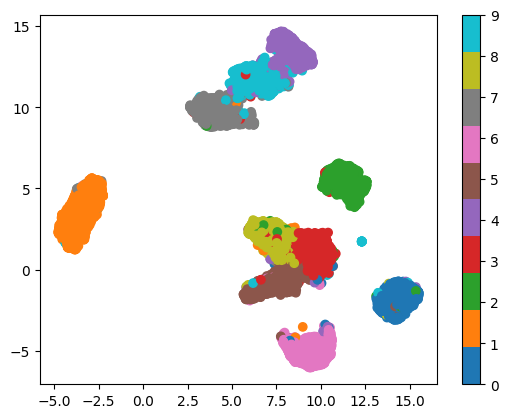

In [10]:
plot_umap_latent(py_autoencoder, val_loader)

In [ ]:
x_train.shape

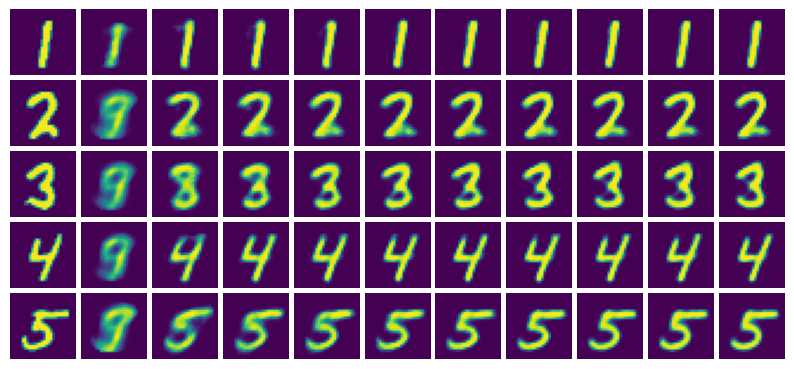

In [13]:
plot_reconstructed(log_dict)